In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import hamming_loss
from sklearn.model_selection import KFold
from sklearn.decomposition import TruncatedSVD
import sklearn.feature_extraction.text as extraction

%matplotlib inline

In [2]:
# load data as dataframes
features = pd.read_csv('features_vectorized.csv', delimiter=',')
labels = pd.read_csv('labels.csv', delimiter=',')

In [8]:
# 50% covar, code 'borrowed' from Hamilton
shortX = pd.read_csv('features.csv')
tfidfVector = extraction.TfidfVectorizer()
tfidf = tfidfVector.fit_transform(shortX.pop('title'))
key = {v: k for k,v in tfidfVector.vocabulary_.items()}
words = pd.DataFrame(tfidf.todense())
words.rename(columns=key, inplace=True)
words50 = TruncatedSVD(773).fit_transform(words)

In [3]:
# convert pandas dataframe to numpy arrays
features = features.to_numpy()
labels = labels.to_numpy()

In [4]:
# k-fold crossvalidation with 10 folds
kf = KFold(n_splits=10, random_state=1, shuffle=True)

# calculate accuracy and loss
result = np.zeros(10)
loss = np.zeros(10)
genre_neigh = KNeighborsClassifier(n_neighbors=13)
i = 0
for train_idx, test_idx in kf.split(features):
    X_train2, X_test2 = features[train_idx], features[test_idx]
    y_train2, y_test2 = labels[train_idx], labels[test_idx]
    genre_neigh.fit(X_train2, y_train2)
    y_predict2 = genre_neigh.predict(X_test2)
    result[i] = genre_neigh.score(X_test2, y_test2)
    loss[i] = hamming_loss(y_test2, y_predict2)
    i += 1

In [11]:
# calculate accuracy and loss with 50% covar, 10 fold CV
result_50 = np.zeros(10)
loss_50 = np.zeros(10)
i = 0
for train_idx, test_idx in kf.split(words50):
    X_train3, X_test3 = words50[train_idx], words50[test_idx]
    y_train3, y_test3 = labels[train_idx], labels[test_idx]
    genre_neigh.fit(X_train3, y_train3)
    y_predict3 = genre_neigh.predict(X_test3)
    result_50[i] = genre_neigh.score(X_test3, y_test3)
    loss_50[i] = hamming_loss(y_test3, y_predict3)
    i += 1

<function matplotlib.pyplot.show(*args, **kw)>

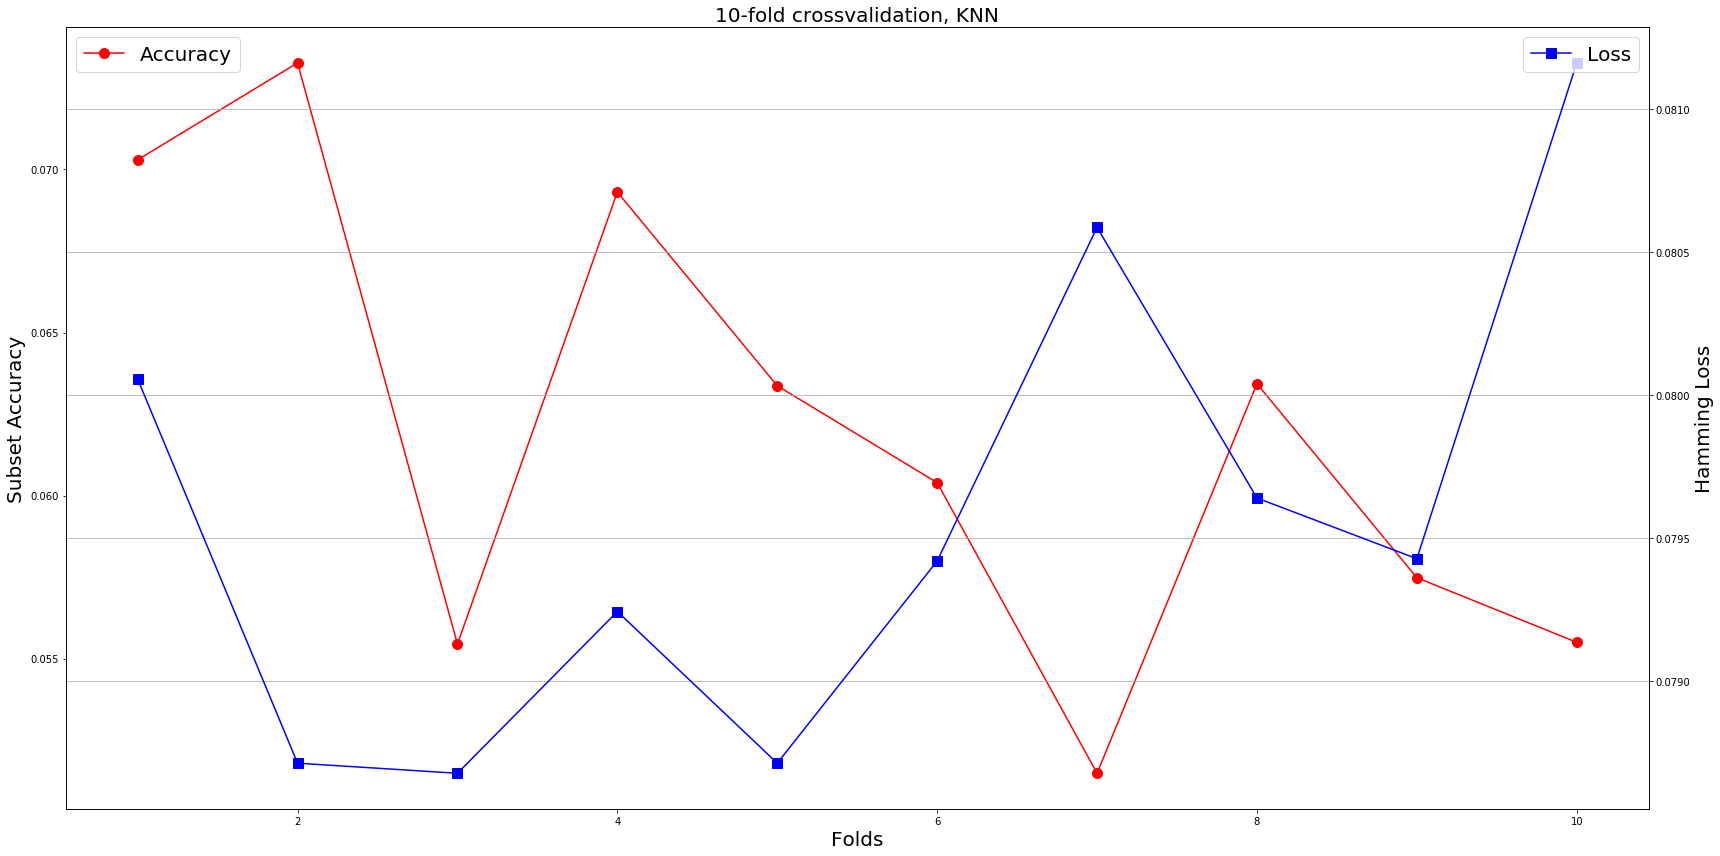

In [37]:
# plot subset accuracy and Hamming loss
fig, ax1 = plt.subplots(figsize=(24,12))
ax1.set_xlabel('Folds',fontsize=20)
ax1.set_ylabel('Subset Accuracy',fontsize=20)
ax1.plot(np.arange(1,11), result, color='red',marker='o',markersize=10)
ax1.legend(['Accuracy'],loc=2,fontsize=20)

ax2 = ax1.twinx()

ax2.set_ylabel('Hamming Loss',fontsize=20)
ax2.plot(np.arange(1,11), loss, color='blue',marker='s',markersize=10)
ax2.legend(['Loss'],loc=1,fontsize=20)

plt.title('10-fold crossvalidation, KNN',fontsize=20)
fig.tight_layout()
plt.grid(1)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

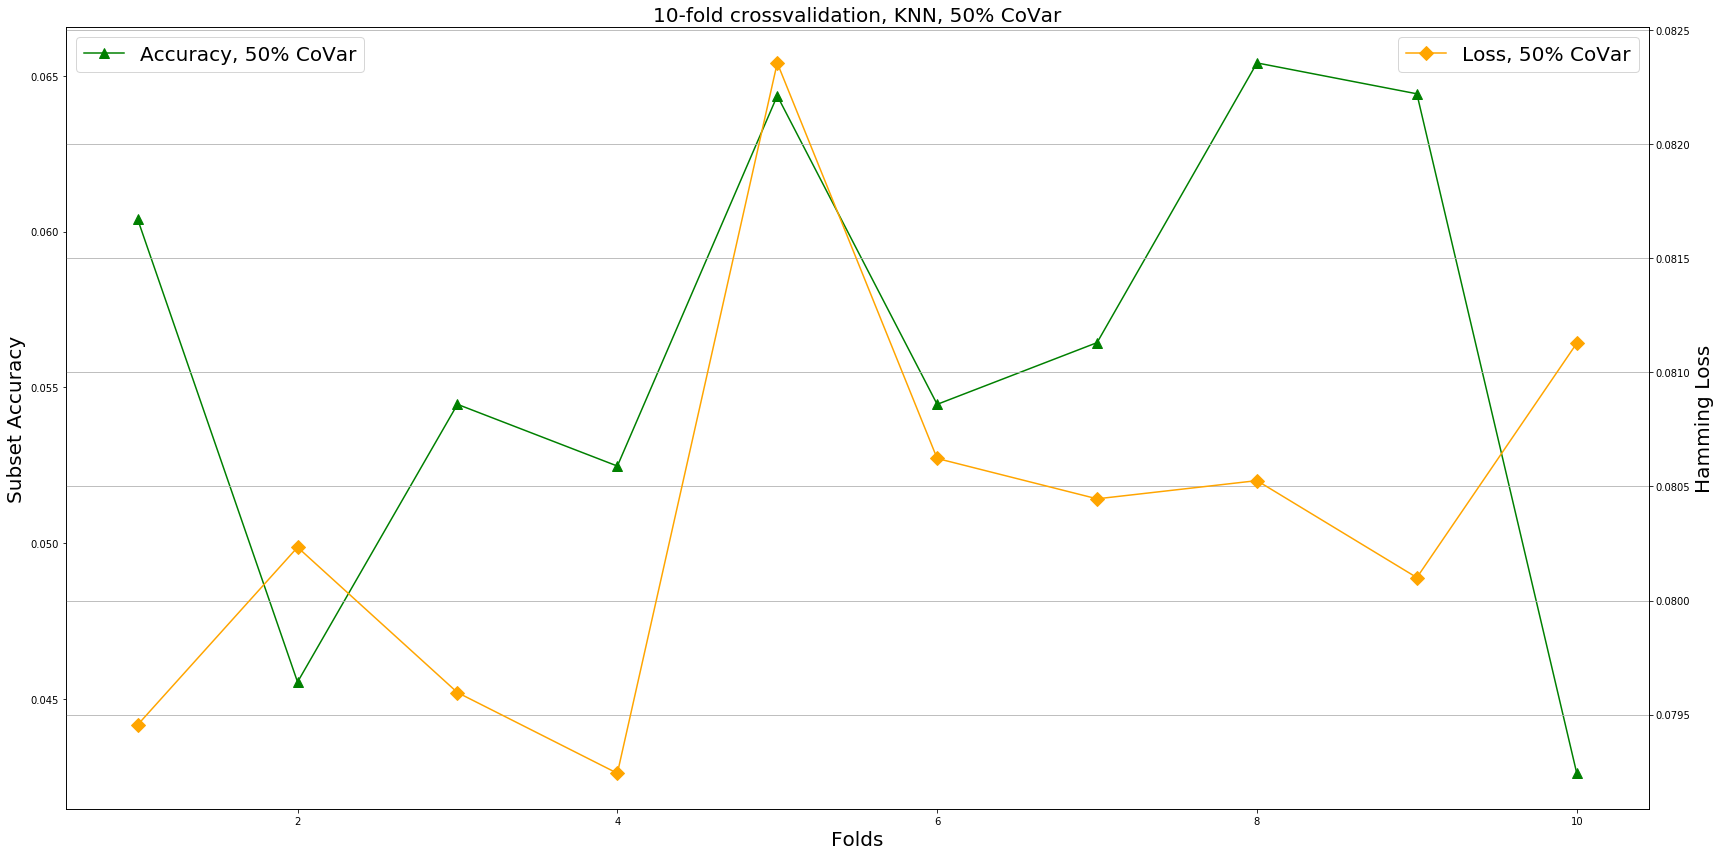

In [35]:
# plot subset accuracy and Hamming loss, 50% CoVar
fig, ax1 = plt.subplots(figsize=(24,12))
ax1.set_xlabel('Folds',fontsize=20)
ax1.set_ylabel('Subset Accuracy',fontsize=20)
ax1.plot(np.arange(1,11), result_50, color='green',marker='^',markersize=10)
ax1.legend(['Accuracy, 50% CoVar'],loc=2,fontsize=20)

ax2 = ax1.twinx()

ax2.set_ylabel('Hamming Loss',fontsize=20)
ax2.plot(np.arange(1,11), loss_50, color='orange',marker='D',markersize=10)
ax2.legend(['Loss, 50% CoVar'],loc=1,fontsize=20)

plt.title('10-fold crossvalidation, KNN, 50% CoVar',fontsize=20)
fig.tight_layout()
plt.grid(1)
plt.show

KNN model does not benefit from PCA. In fact, by performing PCA the model produces worse subset accuracy and Hamming loss

In [7]:
# find the optimal k
result_k = []
loss_k = []
j = 0
for train_idx, test_idx in kf.split(features):
    if j == 1:
        X_train_f, X_test_f = features[train_idx], features[test_idx]
        y_train_f, y_test_f = labels[train_idx], labels[test_idx]
    j += 1

for k in np.arange(3,60,2):
    genre_neigh = KNeighborsClassifier(n_neighbors=k)
    genre_neigh.fit(X_train_f, y_train_f)
    y_predict_f = genre_neigh.predict(X_test_f)
    result_k = np.append(result_k,genre_neigh.score(X_test_f, y_test_f))
    loss_k = np.append(loss_k, hamming_loss(y_test_f, y_predict_f))

<function matplotlib.pyplot.show(*args, **kw)>

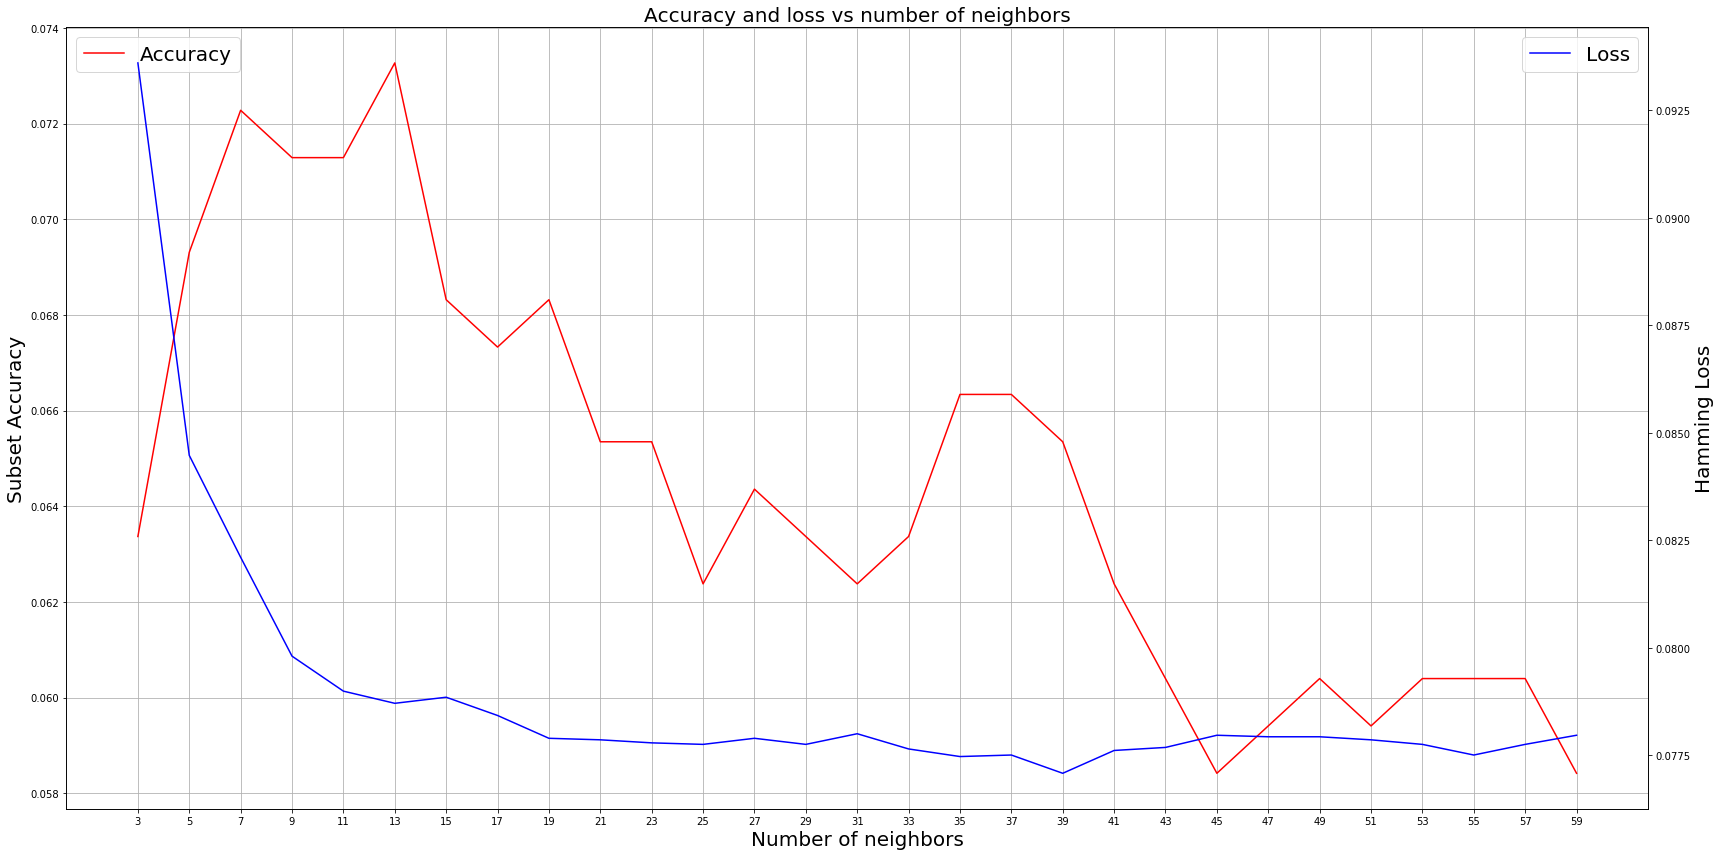

In [16]:
# plot subset accuracy and Hamming loss
fig, ax1 = plt.subplots(figsize=(24,12))
ax1.set_xlabel('Number of neighbors',fontsize=20)
ax1.set_ylabel('Subset Accuracy',fontsize=20)
ax1.plot(np.arange(3,60,2), result_k, color='red')
ax1.legend(['Accuracy'],loc=2,fontsize=20)


ax2 = ax1.twinx()

ax2.set_ylabel('Hamming Loss',fontsize=20)
ax2.plot(np.arange(3,60,2), loss_k, color='blue')
ax2.legend(['Loss'],loc=1,fontsize=20)

plt.title('Accuracy and loss vs number of neighbors',fontsize=20)
fig.tight_layout()
ax1.grid(1,axis='both')
plt.xticks(np.arange(3,60,2))
plt.show

The best balance between subset accuracy and Hamming loss occurs when k=13